In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances
import os

sns.set_style('white')
%matplotlib inline

## The dessert problem

Take a look at the preferences for desserts in the [KERMIT](kermit.ugent.be) research unit.

In [2]:
# preferences
preferences = pd.DataFrame([
    [2, 2, 1, 0, 0],
    [0, -2, -2, -2, 2],
    [1, 2, 2, 2, -1],
    [2, 1, 0, 1, -1],
    [0.5, 2, 2, 1, 0],
    [0, 1, 1, 1, -1],
    [-2, 2, 2, 1, 1],
    [2, 1, 2, 1, -1]
], index=['Bernard', 'Jan', 'Willem', 'Hilde', 'Steffie', 'Marlies', 'Tim', 'Wouter'])

preferences.columns = ['merveilleux', 'eclair', 'chocolate mousse', 'bavarois', 'carrot cake']

M = - preferences.values # cost is negative preferences

# prortions per person
portions_per_person = pd.DataFrame([[3],
                                    [3],
                                    [3],
                                    [4],
                                    [2],
                                    [2],
                                    [2],
                                    [1]],
                    index=['Bernard', 'Jan', 'Willem', 'Hilde', 'Steffie',
                                            'Marlies', 'Tim', 'Wouter'])
# quantities
quantities_of_dessert = pd.DataFrame([  [4],
                                        [2],
                                        [6],
                                        [4],
                                        [4]],
                                        index=['merveilleux', 'eclair', 'chocolate mousse',
                                                   'bavarois', 'carrot cake'])

In [27]:
print(preferences.to_markdown())

|         |   merveilleux |   eclair |   chocolate mousse |   bavarois |   carrot cake |
|:--------|--------------:|---------:|-------------------:|-----------:|--------------:|
| Bernard |           2   |        2 |                  1 |          0 |             0 |
| Jan     |           0   |       -2 |                 -2 |         -2 |             2 |
| Willem  |           1   |        2 |                  2 |          2 |            -1 |
| Hilde   |           2   |        1 |                  0 |          1 |            -1 |
| Steffie |           0.5 |        2 |                  2 |          1 |             0 |
| Marlies |           0   |        1 |                  1 |          1 |            -1 |
| Tim     |          -2   |        2 |                  2 |          1 |             1 |
| Wouter  |           2   |        1 |                  2 |          1 |            -1 |


How many portions per person.

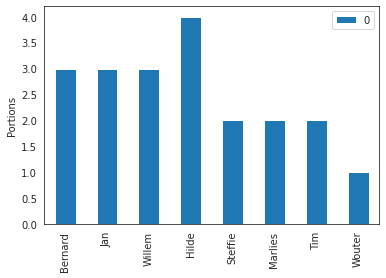

In [28]:
ax = portions_per_person.plot(kind='bar')
ax.set_ylabel('Portions')
r = portions_per_person.values.ravel()  # store as vector

How much of every dessert.

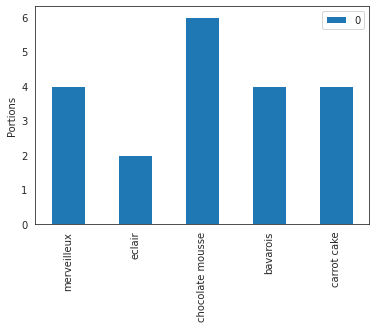

In [29]:
ax = quantities_of_dessert.plot(kind='bar')
ax.set_ylabel('Portions')
plt.savefig('2.png')
c = quantities_of_dessert.values.ravel()  # store as vector

Compute optimal transport (low entropic regularization).

In [5]:
def compute_optimal_transport(M, r, c, lam, epsilon=1e-5):
    """
    Computes the optimal transport matrix and Slinkhorn distance using the
    Sinkhorn-Knopp algorithm

    Inputs:
        - M : cost matrix (n x m)
        - r : vector of marginals (n, )
        - c : vector of marginals (m, )
        - lam : strength of the entropic regularization
        - epsilon : convergence parameter

    Output:
        - P : optimal transport matrix (n x m)
        - dist : Sinkhorn distance
    """
    n, m = M.shape
    P = np.exp(- lam * M)
    # Avoiding poor math condition
    P /= P.sum()
    u = np.zeros(n)
    # Normalize this matrix so that P.sum(1) == r, P.sum(0) == c
    while np.max(np.abs(u - P.sum(1))) > epsilon:
        # Shape (n, )
        u = P.sum(1)
        P *= (r / u).reshape((-1, 1))
        P *= (c / P.sum(0)).reshape((1, -1))
    return P, np.sum(P * M)

Sinkhorn distance: -35.99503084811552


Text(0.5, 1.0, 'Optimal distribution ($\\lambda=10$)')

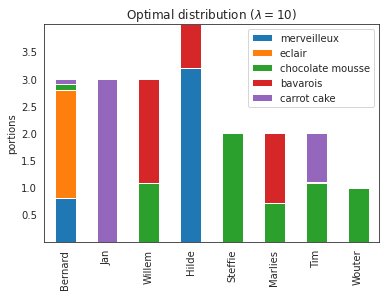

In [6]:
lam = 10

P, d = compute_optimal_transport(M,
        r,
        c, lam=lam)

partition = pd.DataFrame(P, index=preferences.index, columns=preferences.columns)
ax = partition.plot(kind='bar', stacked=True)
print('Sinkhorn distance: {}'.format(d))
ax.set_ylabel('portions')
ax.set_title('Optimal distribution ($\lambda={}$)'.format(lam))

Sinkhorn distance: -29.626510743466827


Text(0.5, 1.0, 'Optimal distribution ($\\lambda=1$)')

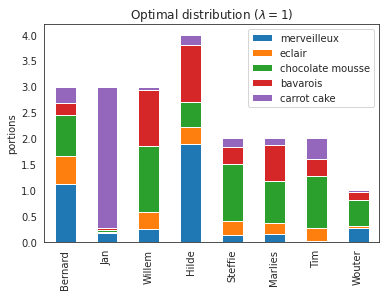

In [7]:
lam = 1

P, d = compute_optimal_transport(M,
        r,
        c, lam=lam)

partition = pd.DataFrame(P, index=preferences.index, columns=preferences.columns)
ax = partition.plot(kind='bar', stacked=True)
print('Sinkhorn distance: {}'.format(d))
ax.set_ylabel('portions')
ax.set_title('Optimal distribution ($\lambda={}$)'.format(lam))

## Matching distributions: circles

In [8]:
from sklearn.datasets import make_circles

# two concentric circles
X, y = make_circles(n_samples=500, noise=0.05,
                    factor=0.5, shuffle=False)
X1 = X[y==0]
X2 = X[y==1]

n, m = len(X1), len(X2)

In [9]:
# Distance metric
M = pairwise_distances(X1, X2, metric='euclidean')
# Uniform weights
n, m = M.shape
r = np.ones(n) / n
c = np.ones(m) / m
P, d = compute_optimal_transport(M, r, c, lam=100, epsilon=1e-6)

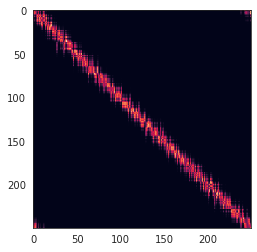

In [10]:
plt.imshow(P)

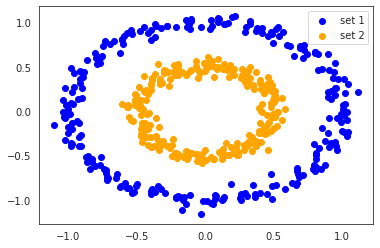

In [11]:
fig, ax = plt.subplots()

ax.scatter(X1[:,0], X1[:,1], color='blue', label='set 1')
ax.scatter(X2[:,0], X2[:,1], color='orange', label='set 2')
ax.legend(loc=0)

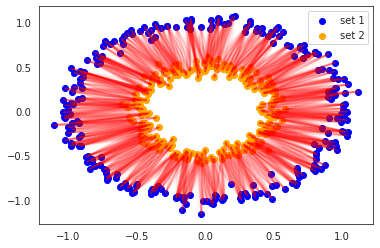

In [12]:
fig, ax = plt.subplots()

ax.scatter(X1[:,0], X1[:,1], color='blue', label='set 1')
ax.scatter(X2[:,0], X2[:,1], color='orange', label='set 2')

ax.legend(loc=0)

for i in range(n):
    for j in range(m):
        if P[i,j] > 1e-5:
            ax.plot([X1[i,0], X2[j,0]], [X1[i,1], X2[j,1]], alpha=P[i,j] * n, color='red')
    

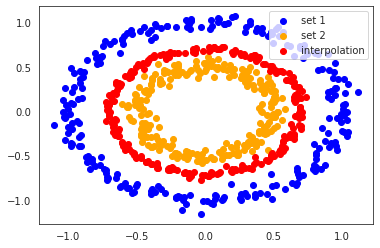

In [13]:
"""
Interpolate between the two distributions.

Input:
    - alpha : value between 0 and 1 for the interpolation

Output:
    - X : the interpolation between X1 and X2
    - w : weights of the points
"""
alpha = 0.6
mixing = P.copy()
# Normalize, so each row sums to 1 (i.e. probability)
mixing /= r.reshape((-1, 1))
X = (1 - alpha) * X1 + alpha * mixing @ X2
w = (1 - alpha) * r + alpha * mixing @ c

fig, ax = plt.subplots()

ax.scatter(X1[:,0], X1[:,1], color='blue', label='set 1')
ax.scatter(X2[:,0], X2[:,1], color='orange', label='set 2')

ax.scatter(X[:,0], X[:,1], color='red', label='interpolation')
ax.legend(loc=1)

## Domain transfer

We make a small classification problem and divide in train and test. The test set is perturbated (shift + noise)

In [14]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split


Xtr, Xte, ytr, yte = train_test_split(*make_blobs(n_samples=200, centers=3, cluster_std=1.5), test_size=0.5)

Xte += np.random.randn(*Xte.shape) * 2 + np.array([[2, -3]]) 

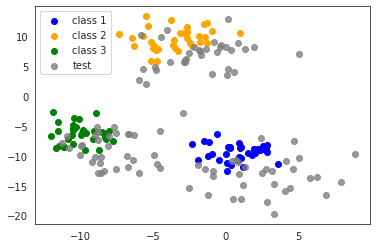

In [15]:
fig, ax = plt.subplots()

for cl, col in zip(range(3), ['blue','orange', 'green']):
    X = Xtr[ytr==cl,:]
    ax.scatter(X[:,0], X[:,1], color=col, label='class {}'.format(cl+1))
    
ax.scatter(Xte[:,0], Xte[:,1], color='gray', alpha=0.8, label='test') 
ax.legend(loc=0)

In [16]:
# Distance metric
M = pairwise_distances(Xtr, Xte, metric='euclidean')
# Uniform weights
n, m = M.shape
r = np.ones(n) / n
c = np.ones(m) / m
P, d = compute_optimal_transport(M, r, c, lam=50, epsilon=1e-6)

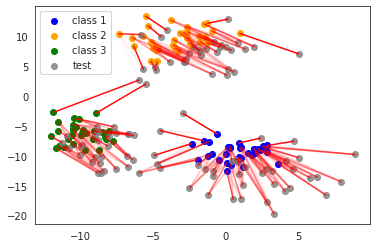

In [17]:
fig, ax = plt.subplots()

for i in range(Xtr.shape[0]):
    for j in range(Xte.shape[0]):
        if P[i,j] > 1e-4:
            ax.plot([Xtr[i,0], Xte[j,0]], [Xtr[i,1], Xte[j,1]], color='red', alpha=P[i,j]*100)
            
for cl, col in zip(range(3), ['blue','orange', 'green']):
    X = Xtr[ytr==cl,:]
    ax.scatter(X[:,0], X[:,1], color=col, label='class {}'.format(cl+1))
    
ax.scatter(Xte[:,0], Xte[:,1], color='gray', alpha=0.8, label='test')
            
ax.legend(loc=0)

## Color transfer

See `color_transfer.py` module!

Image from:

![Princess Caroline](Figures/PC.jpg)

Image to:

![Mr. Peanutbutter](Figures/PB.jpg)

In [18]:
import numpy as np
from skimage import io
from skimage.color import rgb2hsv, hsv2rgb
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
import warnings
warnings.simplefilter("ignore", UserWarning)

# get arguments
name_from = 'Figures/PB.jpg'
name_to = 'Figures/PC.jpg'
name_out = 'Figures/PB2PC.jpg'
n_pixels = 1000
lam = 10
n_neighbors = 10
distance_metric = 'euclidean'

def im2mat(I):
    """Converts and image to matrix (one pixel per line)"""
    return I.reshape((I.shape[0] * I.shape[1], I.shape[2]))

def mat2im(X, shape):
    """Converts back a matrix to an image"""
    return X.reshape(shape)

def minmax(I):
    return np.clip(I, 0, 1)

def join_path(path):
    return os.path.join(os.path.abspath('.'), path)

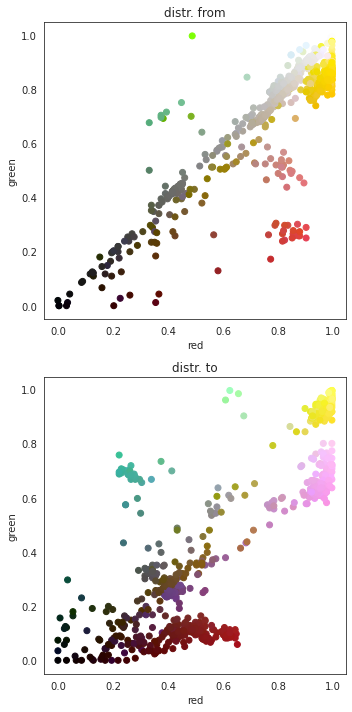

In [19]:
# read the images
image_from = io.imread(join_path(name_from)) / 256
image_to = io.imread(join_path(name_to)) / 256

# get shapes
shape_from = image_from.shape
shape_to = image_to.shape

# flatten
X_from = im2mat(image_from)
X_to = im2mat(image_to)

# subsample, only retain n_pixels pixels.
rng = np.random.default_rng(0)
X_from_ss = rng.choice(X_from, size=n_pixels, axis=0, replace=False, shuffle=False)
X_to_ss = rng.choice(X_to, size=n_pixels, axis=0, replace=False, shuffle=False)

fig, axes = plt.subplots(nrows=2, figsize=(5, 10))
for ax, X in zip(axes, [X_from_ss, X_to_ss]):
    ax.scatter(X[:,0], X[:,1], color=X)
    ax.set_xlabel('red')
    ax.set_ylabel('green')
axes[0].set_title('distr. from')
axes[1].set_title('distr. to')
fig.tight_layout()
fig.savefig(join_path('Figures/color_distributions.png'))

In [20]:
# optimal tranportation
# Distance metric: 'euclidean'
M = pairwise_distances(X_to_ss, X_from_ss, metric=distance_metric)
# Uniform weights
n, m = M.shape
r = np.ones(n) / n
c = np.ones(m) / m
P, d = compute_optimal_transport(M, r, c, lam=lam, epsilon=1e-6)

In [21]:
# model transfer
transfer_model = KNeighborsRegressor(n_neighbors=n_neighbors)
transfer_model.fit(X_to_ss, np.matmul(P / r.reshape((-1, 1)), X_from_ss))
X_transfered = transfer_model.predict(X_to)

image_transferd = minmax(mat2im(X_transfered, shape_to))
io.imsave(join_path(name_out), image_transferd)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Result:

![Colors of mr. Peanutbutter to Princess caroline.](Figures/PB2PC.jpg)

## References

Lévy, B. and Schwindt, E. (2017). *Notions of optimal transport theory and how to implement them on a computer* [arxiv](https://arxiv.org/pdf/1710.02634.pdf)

Courty, N., Flamary, R., Tuia, D. and Rakotomamonjy, A. (2016). *Optimal transport for domain adaptation*

Cuturi, M. (2013) *Sinkhorn distances: lightspeed computation of optimal transportation distances*
